In [4]:
import numpy as np
import fbpca 


def prep_data():
    x = np.loadtxt("simulated_genos", delimiter=" ", dtype="float32")
    y = np.array([[1] * 10000 + [0] * 10000], dtype="float32")
    y_c = y - 0.5
    return x, y_c

x, y_c = prep_data()
print (x.shape)


(20000, 50)


In [5]:
# fbpca

%time sig_rsvd_fbpca = fbpca.pca(x,50,True)[1]
eig_rsvd_fbpca = sig_rsvd_fbpca ** 2
print (eig_rsvd_fbpca)


CPU times: user 53.8 ms, sys: 20.3 ms, total: 74 ms
Wall time: 102 ms
[ 40.00001144  38.08315277  37.10234833  37.06640244  37.00000763
  33.04753876  31.16459846  29.1289978   29.07105446  29.03992844
  28.99998474  28.00000381  27.65703964  26.03939819  25.52819252
  25.03122902  25.00000572  24.00005341  23.99998283  22.00000954
  21.93363762  21.00001335  20.68578529  20.00000572  20.00000572
  19.80418396  17.82784653  16.94734573  16.          15.99999428
  14.92892456  13.00000191  11.99999332  11.95249748  11.00000381
  10.99999619  10.00000668  10.00000286  10.           9.00000286
   7.99999857   7.00000095   7.00000095   6.99999952   6.00000286   5.           4.
   4.           3.96006298   1.        ]


In [6]:
#randomized SVD
def randomized_svd(M, k=10):
    m, n = M.shape
    transpose = False
    if m < n:
        transpose = True
        M = M.T
        
    rand_matrix = np.random.normal(size=(M.shape[1], k))  # short side by k
    Q, _ = np.linalg.qr(M @ rand_matrix, mode='reduced')  # long side by k
    smaller_matrix = Q.T @ M                              # k by short side
    U_hat, s, V = np.linalg.svd(smaller_matrix, full_matrices=False)
    U = Q @ U_hat
    
    if transpose:
        return V.T, s.T, U.T
    else:
        return U, s, V
    
%time sig_rsvd = randomized_svd(x,50)[1]
eig_rsvd = sig_rsvd_fbpca ** 2
print (eig_rsvd)

CPU times: user 104 ms, sys: 31.1 ms, total: 136 ms
Wall time: 95.7 ms
[ 40.00001144  38.08315277  37.10234833  37.06640244  37.00000763
  33.04753876  31.16459846  29.1289978   29.07105446  29.03992844
  28.99998474  28.00000381  27.65703964  26.03939819  25.52819252
  25.03122902  25.00000572  24.00005341  23.99998283  22.00000954
  21.93363762  21.00001335  20.68578529  20.00000572  20.00000572
  19.80418396  17.82784653  16.94734573  16.          15.99999428
  14.92892456  13.00000191  11.99999332  11.95249748  11.00000381
  10.99999619  10.00000668  10.00000286  10.           9.00000286
   7.99999857   7.00000095   7.00000095   6.99999952   6.00000286   5.           4.
   4.           3.96006298   1.        ]


In [13]:

#exact:
from scipy import sparse
import scipy.sparse.linalg as lg
X_sparse = sparse.csr_matrix(x)
X_T_sparse = sparse.csr_matrix.transpose(X_sparse)
XX = X_sparse@X_T_sparse
%time eig_exact = lg.eigsh(XX,k=50)
eig_exact = sorted(eig_exact[0],reverse = True)
print (eig_exact)


CPU times: user 212 ms, sys: 5.1 ms, total: 217 ms
Wall time: 132 ms
[40.000008, 38.083118, 37.102318, 37.066357, 37.0, 33.047501, 31.164595, 29.128979, 29.071066, 29.039942, 29.000004, 27.999998, 27.657055, 26.039402, 25.528193, 25.031223, 24.999998, 24.000011, 24.000008, 21.999998, 21.933632, 21.000002, 20.685776, 20.000002, 20.000002, 19.804171, 17.82782, 16.947344, 16.000002, 15.999995, 14.928931, 12.999998, 12.000002, 11.952483, 11.000003, 10.999998, 10.000003, 10.000002, 10.000001, 9.0000029, 7.9999995, 7.0000086, 7.000001, 6.999999, 6.0, 4.9999971, 4.0000086, 4.0000014, 3.9600585, 0.99998844]


In [17]:
# compare approximate methods to exact method's eigen
eig_rsvd = list(eig_rsvd)

total_error = 0
for i in range(len(eig_rsvd)):
    error = abs(eig_rsvd[i]-eig_exact[i])
    total_error += error
mean_error = total_error/len(eig_rsvd)
print ("total error: ")
print (total_error)
print ("average error:")
print (mean_error)

total error: 
0.000505328178406
average error:
1.01065635681e-05


[ 2.01407211  0.1030275   1.66812402 ...,  0.06259038  3.31131503
  7.5345994 ]


(array([  2.,   3.,   9.,  13.,  28.,  45.,  47.,  58.,  81.,  76.,  91.,
         86.,  83.,  64.,  65.,  49.,  44.,  36.,  26.,  28.,  17.,  12.,
         11.,   9.,   6.,   6.,   1.,   0.,   2.,   2.]),
 array([  419.50596116,   463.98536757,   508.46477399,   552.94418041,
          597.42358682,   641.90299324,   686.38239965,   730.86180607,
          775.34121248,   819.8206189 ,   864.30002531,   908.77943173,
          953.25883815,   997.73824456,  1042.21765098,  1086.69705739,
         1131.17646381,  1175.65587022,  1220.13527664,  1264.61468305,
         1309.09408947,  1353.57349589,  1398.0529023 ,  1442.53230872,
         1487.01171513,  1531.49112155,  1575.97052796,  1620.44993438,
         1664.92934079,  1709.40874721,  1753.88815363]),
 <a list of 30 Patch objects>)

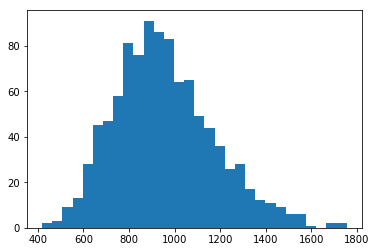

In [38]:
# Monte Carlo, simulate the distribution of Q
import matplotlib.pyplot as plt
%matplotlib inline

#generate chi-square r.v
N = 10000


chisq_list = np.random.chisquare(1, size=N)
print (chisq_list)

Q_distribution = []
for i in range(1000):
    sample = np.random.choice(chisq_list, 50, replace=False)
    Q_stat = np.sum(eig_exact * sample)
    Q_distribution.append(Q_stat)
    


#print (Q_distribution)
plt.hist(Q_distribution, bins = 30)





#### Process behind Randomized SVD

Here is a process to calculate a truncated SVD, described in [Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions](https://arxiv.org/pdf/0909.4061.pdf) and [summarized in this blog post](https://research.fb.com/fast-randomized-svd/):

1\. Compute an approximation to the range of $A$. That is, we want $Q$ with $r$ orthonormal columns such that $$A \approx QQ^TA$$


2\. Construct $B = Q^T A$, which is small ($r\times n$)


3\. Compute the SVD of $B$ by standard methods (fast since $B$ is smaller than $A$), $B = S\,\Sigma V^T$

4\. Since $$ A \approx Q Q^T A = Q (S\,\Sigma V^T)$$ if we set $U = QS$, then we have a low rank approximation $A \approx U \Sigma V^T$.

#### So how do we find $Q$ (in step 1)?

To estimate the range of $A$, we can just take a bunch of random vectors $w_i$, evaluate the subspace formed by $Aw_i$.  We can form a matrix $W$ with the $w_i$ as it's columns.  Now, we take the QR decomposition of $AW = QR$, then the columns of $Q$ form an orthonormal basis for $AW$, which is the range of $A$.

Since the matrix $AW$ of the product has far more rows than columns and therefore, approximately, orthonormal columns. This is simple probability - with lots of rows, and few columns, it's unlikely that the columns are linearly dependent.

#### Why M ~ Q Q.T M

We are trying to find a matrix Q such that $M \approx Q Q^T M$.  We are interested in the range of $M$, let's call this $MX$.  $Q$ has orthonormal columns so $Q^TQ = I$ (but $QQ^T$ isn't $I$, since $Q$ is rectangular)

$$ QR = MX $$
$$ QQ^TQR = QQ^TMX $$
$$ QR = QQ^TMX $$
so...
$$ MX = QQ^TMX $$

If $X$ is the identity, we'd be done (but then $X$ would be too big, and we wouldn't get the speed up we're looking for).  In our problem, $X$ is just a small random matrix.  The Johnson-Lindenstrauss Lemma provides some justification of why this works.

#### The QR Decomposition

We will be learning about the QR decomposition **in depth** later on.  For now, you just need to know that $A = QR$, where $Q$ consists of orthonormal columns, and $R$ is upper triangular.  Trefethen says that the QR decomposition is the most important idea in numerical linear algebra!  We will definitely be returning to it.

#### How should we choose $r$?

Suppose our matrix has 100 columns, and we want 5 columns in U and V. To be safe, we should project our matrix onto an orthogonal basis with a few more rows and columns than 5 (let's use 15).  At the end, we will just grab the first 5 columns of U and V

So even although our projection was only approximate, by making it a bit bigger than we need, we can make up for the loss of accuracy (since we're only taking a subset later). 